In [66]:
import pandas as pd
import matplotlib.pyplot as plt

import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta

import time

# Config & functions

In [166]:
df_account = None

## Function Save to excel with multiple sheet
def DF_TO_EXCEL_MUL(dfs, filename):
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    for sheetname, df in dfs.items():  # loop through `dict` of dataframes
        df.to_excel(writer, sheet_name=sheetname)  # send df to writer
        worksheet = writer.sheets[sheetname]  # pull worksheet object
        for idx, col in enumerate(df):  # loop through all columns
            series = df[col]
            max_len = max((
                series.astype(str).map(len).max(),  # len of largest item
                len(str(series.name))  # len of column name/header
                )) + 1  # adding a little extra space
            worksheet.set_column(idx, idx, max_len)  # set column width
    writer.save()

## Load Account Name
def get_account():
    df_account = pd.read_excel('data/List of well-known Names used to identify accounts.xlsx')
    df_account.fillna('', inplace=True)
    df_account = df_account.sort_values(by='XRP', ascending=False)
    return df_account

## Find Account Description
def find_account_desc(account):
    if not dir().count('df_account'):
        df_account = get_account()
        
    try:
        _df = df_account.loc[df_account.account == account, ['name','desc']].astype(str)
        return '{}{}'.format(_df.name.values[0], '({})'.format(_df.desc.values[0]) if len(_df.desc.values[0]) > 0 else '')
    except:
        return 'Unknow'

## Get account balances
def get_balances(ACCOUNT_ADDRESS, days=90):
    now = datetime.now()  - timedelta(days=days)
    date_time = now.strftime("%Y-%m-%d")
    trans_list = []
    
    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }
    
    for i in range(1, days+2):

        date_time = now.strftime("%Y-%m-%d")

        url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)
        r = requests.get(url, headers=header)
        data = json.loads(r.text)

        if data['result'] != 'error':
            value = float(data['balances'][0]['value'])
            trans_list.append([ACCOUNT_ADDRESS, date_time, value])

        now = now  + timedelta(days=1)

    df_balance = pd.DataFrame(trans_list, columns=['Account', 'Date', 'Balance'])
    df_balance.set_index(['Date'], inplace=True)
    
    return df_balance

## Get transactions
def get_transactions(ACCOUNT_ADDRESS, days, limit, descending):
    start = datetime.now() - timedelta(days=days)
    date_start = start.strftime("%Y-%m-%dT%H:%M:%SZ")

    end = datetime.now()
    date_end = end.strftime("%Y-%m-%dT%H:%M:%SZ")

    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/transactions?start={date_start}&end={date_end}&type=Payment&result=tesSUCCESS&limit={limit}&descending={descending}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_start=date_start, date_end=date_end, limit=limit, descending=descending)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    return data

## Convert JSON to DataFrame
def convert_to_dataframe(account, data):
    
    df_trans = pd.DataFrame()
    
    if data['result'] == "error":
        print(data['message'])
        return df_trans
    
    if data['count'] == 0:
        print('Data not found!')
        return df_trans
    
    trans_list=[]
    for d in data['transactions']:
        account_desc = ''
        d_date = d['date']
        d_hash = d['hash']
        d_tx_from = d['tx']['Account']
        d_tx_from_desc = ''
        d_tx_type = d['tx']['TransactionType']
        d_tx_flow = ''
        d_tx_to = d['tx']['Destination']
        d_tx_to_desc = ''
        d_tx_dt = d['tx']['DestinationTag'] if d['tx'].__contains__('DestinationTag') else ''
        
        d_tx_amount = 0
        d_tx_currency = ''
        d_tx_issuer = ''
        if str(type(d['tx']['Amount'])) != "<class 'dict'>":
            d_tx_amount = float(d['tx']['Amount'])  / 1000000
        else:
            d_tx_amount = float(d['tx']['Amount']['value']) / 1000000
            d_tx_currency = d['tx']['Amount']['currency'][0:8]
            d_tx_issuer = d['tx']['Amount']['issuer']
        
        d_meta_delivered_amount = 0
        if str(type(d['meta']['delivered_amount'])) != "<class 'dict'>":
            d_meta_delivered_amount =  float(d['meta']['delivered_amount'])  / 1000000
        else:
            d_meta_delivered_amount =  float(d['meta']['delivered_amount']['value'])  / 1000000
            
        d_tx_fee = float(d['tx']['Fee']) / 1000000
        d_meta_result = d['meta']['TransactionResult']

        trans_list.append([account, account_desc, d_date, d_hash, d_tx_from, d_tx_from_desc, d_tx_type, d_tx_flow, d_tx_to, d_tx_to_desc, d_tx_dt, d_tx_amount, d_tx_currency, d_tx_issuer, d_meta_delivered_amount, d_tx_fee, d_meta_result])

    df_trans = pd.DataFrame(trans_list, columns=['account','Account Desc', 'Date','Tx hash','From','From Desc','Type','Flow','To','To Desc','DT','Amount', 'Currency', 'Issuer', 'Delivered Amount', 'Fee', 'Result'])
    
    df_trans['Account Desc'] = df_trans['account'].apply(lambda x: find_account_desc(x))
    df_trans['From Desc'] = df_trans['From'].apply(lambda x: find_account_desc(x))
    df_trans['To Desc'] = df_trans['To'].apply(lambda x: find_account_desc(x))
    df_trans['Flow'] = df_trans[['account', 'To']].apply(lambda x: 'IN' if x['account'] == x['To'] else 'OUT', axis=1)
    
    return df_trans

def get_account_info(ACCOUNT_ADDRESS):
    url = 'https://api.xrpscan.com/api/v1/account//{ACCOUNT_ADDRESS}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    acc_list = {'account': [data['account']], 'accountName':['{}{}'.format(data['accountName']['name'], '({})'.format(data['accountName']['desc']) if 'desc' in data['accountName'] else '') if data['accountName'] != None else 'Unknow'], 'parent': [data['parent']], 'parentName':[ data['parentName']['name'] if data['parentName'] != None else ''] , 'inception':[data['inception']] , 'initial_balance':[ data['initial_balance'] ], 'xrpBalance':[float(data['xrpBalance'])], 'Note':''}
    df_account_info = pd.DataFrame(acc_list, columns=['account','accountName','parent','parentName','inception','initial_balance','xrpBalance', 'Note'])
    
    return df_account_info

# Get account infomation

In [3]:
import requests

ACCOUNT_ADDRESS = 'rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy'
url = 'https://api.xrpscan.com/api/v1/account//{ACCOUNT_ADDRESS}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
data = json.loads(r.text)
JSON(data, expanded=True)


<IPython.core.display.JSON object>

In [ ]:
def get_account_info(ACCOUNT_ADDRESS):
    url = 'https://api.xrpscan.com/api/v1/account//{ACCOUNT_ADDRESS}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    acc_list = {'account': [data['account']], 'parent': [data['parent']], 'parentName':[ data['parentName']['name']] , 'inception':[data['inception']] , 'initial_balance':[ data['initial_balance'] ], 'xrpBalance':[data['xrpBalance']]}
    df_account_info = pd.DataFrame(acc_list, columns=['account','parent','parentName','inception','initial_balance','xrpBalance'])
    
    return df_account_info

# Get Payment flows

In [ ]:
ACCOUNT_ADDRESS = 'rfjW34DYFGF6nZHj8zJJK3dnD7nZoeoAAU'
url = 'https://api.xrpscan.com/api/v1/account/{ACCOUNT_ADDRESS}/payment_flows'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
data = json.loads(r.text)
#JSON(data, expanded=True)
df = json_normalize(data)
df

# Get well-known account

In [14]:
import requests
import json
from pandas.io.json import json_normalize

url = 'https://api.xrpscan.com/api/v1/names/well-known'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

data = json.loads(r.text)
df = json_normalize(data)
df.fillna('', inplace=True)
df

,name,account,domain,twitter,verified,desc
0,1xBet,rP1afBEfikTz7hJh2ExCDni9W4Bx1dUMRk,1xbet.com,1xbetIndia,True,
1,24Paybank,rKs1E7iQxSk8wfEjXiWakZSF1HQUfewSDQ,24paybank.net,24Paybank,True,1
2,24Paybank,rfnonE8R5Fd7gugi9A7h16GUaGx1oDyeqx,24paybank.net,24Paybank,True,2
3,24Paybank,rBq7j6Z5DTWQuxrYooJnkQkV1p9XAfxUt8,24paybank.net,24Paybank,True,3
4,24Paybank,rPXS3wcMVUzuSfrG1qJ8VLr6CWCzuqbbuy,24paybank.net,24Paybank,True,4
...,...,...,...,...,...,...
875,validator.xrptipbot.com,rMYL6sN2z5os4RWLuT6HHDhJYpBACujzNa,validator.xrptipbot.com,xrptipbot,,Validator
876,xCrypto🚀Crash,rK9dBkad6fQ2qkvCJuyCqCGQrcF1fLhoA9,xcryptocrash.com,xcryptocrash,True,
877,xrp.ninja,rnFK6W1E9yykL3gr2Jpt5VZD8aXyUf2uZ3,xrp.ninja,,,Validator
878,xrp1ntel,rhkvfNv6tzh6CMfpXZdX2t7HGN2ZX46Tco,xrp1ntel.com,DevNullProd,True,


In [15]:
df.to_excel('data/List of well-known Names used to identify accounts-v2.xlsx')

# Get Account Balances

In [ ]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta

now = datetime.now() - timedelta(days=1)
date_time = now.strftime("%Y-%m-%d")

ACCOUNT_ADDRESS = 'rEahGW5VLYQH2vGBfFmbv9BBpWSTDoukGR'
url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

data = json.loads(r.text)
JSON(data, expanded=True)

# Get daily reports

In [ ]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta

now = datetime.now() - timedelta(days=1)
date_time = now.strftime("%Y-%m-%d")

url = 'https://data.ripple.com/v2/reports/{date_time}T00:00:00Z?accounts=true&payments=true'.format(date_time=date_time)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

data = json.loads(r.text)
JSON(data, expanded=True)

# Get Account balances

## Today Balance

In [18]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta
import time

df_account = pd.read_excel('data/List of well-known Names used to identify accounts-v2.xlsx')
df_account.fillna('', inplace=True)

now = datetime.now()
date_time = now.strftime("%Y-%m-%d")

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

df_xrp = df_account.copy(deep=True)

print('Begin')

#df_name = df_name.sort_values(by='XRP', ascending=False)
#df_name = df_name[:100] # get top 30 balance

for _, row in df_account.iterrows():
    print('{}-{}-{}'.format(row['account'], row['name'], row['desc']))

    ACCOUNT_ADDRESS = row['account']
    
    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)

    r = requests.get(url, headers=header)

    data = json.loads(r.text)
    
    if 'result' in data:
        if data['result'] == 'success':
            df_xrp.loc[df_xrp['account'] == ACCOUNT_ADDRESS, date_time] = float(data['balances'][0]['value'])

    #print('-----------------------')
    #time.sleep(0.001)   # Delays for 1 seconds. You can also use a float value.

df_xrp['verified'] = df_xrp['verified'].astype(bool)

df_xrp.to_excel('data/{}-List of well-known Names used to identify accounts-v2.xlsx'.format(date_time), index=False)

print('Done.')

Begin
rP1afBEfikTz7hJh2ExCDni9W4Bx1dUMRk-1xBet-
rKs1E7iQxSk8wfEjXiWakZSF1HQUfewSDQ-24Paybank-1
rfnonE8R5Fd7gugi9A7h16GUaGx1oDyeqx-24Paybank-2
rBq7j6Z5DTWQuxrYooJnkQkV1p9XAfxUt8-24Paybank-3
rPXS3wcMVUzuSfrG1qJ8VLr6CWCzuqbbuy-24Paybank-4
rG59copKaAi7LXULVDM1x2oxmdGQaHS2YK-24Paybank-5
r4TYaLUh5axkLo345cinwm5AZD35VqFDdm-24Paybank-6
rE4hmgfnT1QaKXatNyqjs8X9Nw8ZRXi89R-24Paybank-7
rDAyXsUwneT5fsZyJ9AsKL5vSpdeowrART-24Paybank-8
r5LiUJqF3sLpU9g7gzfmUV32DNUM2wf6N-24Paybank-9
rHkewryUaLJJvTdup1cNQ9qFZByeZDWend-24Paybank-10
rBxLSnN9og6LAsiPNWwT5dB5PYKgj7snhb-24Paybank-11
rHvrKyGMCyC2eZ7zryQcnBCfPhvsmWxojj-24Paybank-12
rhQi2Frq1snBNCDnG94z7PnUMWzKR1y79j-24Paybank-13
rH24NE468dwE7qBFEkmKPzsm8TG3xJSaQe-24обмен-
rBh9DJHjRoBHLDrqsnAGJh9RU928bVt919-4ange-10
rEn3iQWhwuiNZB3c3S4aL3nHK1YYM6ZXdt-4ange-1
rpgx464i28DyzFbfwNi6vjv9kZrdYz84Ke-4ange-2
rsawkZ41ts4bFvXxNLUNaxz78P5rSsABvo-4ange-3
r3HRdzyV7rmXMVH8CL2jeZU5p1cjcbSduZ-4ange-4
rKHbwcXs6EEkCdFThZ7RufbbLkiMxkBiq4-4ange-5
rEBViUcsYFS3itGkXL9gAuBsYfsroQjzEQ-

## Get Account Balances History

In [ ]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta
import time

df_account = pd.read_excel('data/List of Monitor Accounts.xlsx')
df_account.fillna('', inplace=True)
df_account['verified'] = df_xrp['verified'].astype(bool)

now = datetime.now()  - timedelta(days=30)
date_time = now.strftime("%Y-%m-%d")

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

df_balance = df_account.copy(deep=True)

print('Begin')

df_account = df_account.sort_values(by='XRP BALANCES', ascending=False)
df_account = df_account[:100] # get top 100 balance

for _, row in df_account.iterrows():
    print('{}-{}-{}'.format(row['account'], row['name'], row['desc']))

    ACCOUNT_ADDRESS = row['account']
    
    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)

    r = requests.get(url, headers=header)

    data = json.loads(r.text)
    if data['result'] != 'error':
        df_balance.loc[df_balance['account'] == ACCOUNT_ADDRESS, date_time] = float(data['balances'][0]['value'])
        
    #print('-----------------------')
    time.sleep(0.001)   # Delays for 1 seconds. You can also use a float value.



df_balance.to_excel('data/{}-List of Monitor Accounts.xlsx'.format(date_time), index=False)

print('Done.')

In [ ]:
df_account = get_account()

In [ ]:

def get_balances(ACCOUNT_ADDRESS, days=90):
    now = datetime.now()  - timedelta(days=days)
    date_time = now.strftime("%Y-%m-%d")
    trans_list = []
    
    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }
    
    for i in range(1, days+1):

        date_time = now.strftime("%Y-%m-%d")

        url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)
        r = requests.get(url, headers=header)
        data = json.loads(r.text)

        if data['result'] != 'error':
            value = float(data['balances'][0]['value'])
            trans_list.append([ACCOUNT_ADDRESS, date_time, value])

        now = now  + timedelta(days=1)

    df_balance = pd.DataFrame(trans_list, columns=['Account', 'Date', 'Balance'])
    df_balance.set_index(['Date'], inplace=True)
    
    return df_balance


## Get Account info

In [4]:

ACCOUNT_ADDRESS = 'rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy'

df_account_info = get_account_info(ACCOUNT_ADDRESS)
ac_list = []
for c in list(df_account_info):
    ac_list.append([c, df_account_info[c].values[0]])
    
cols = ['desc','info']
df_account_info_x = pd.DataFrame(ac_list, columns=cols)
df_account_info_x.set_index('desc', inplace=True)

account_name = df_account_info['accountName'].values[0]

print(df_account_info_x.to_csv(sep='\t'))

desc	info
account	rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy
accountName	Bittrex
parent	rPdWU1d3UteAzp8QbgGMtd7dtKtv7XV8sZ
parentName	
inception	2014-12-22T17:58:40.000Z
initial_balance	20
xrpBalance	8748745.116106
Note	



In [31]:
df_balance = get_balances(ACCOUNT_ADDRESS, 30)
df_balance['Account Desc'] = df_balance['Account'].apply(lambda x: find_account_desc(x))

df_balance

,Account,Balance,Account Desc
Date,,,
2020-04-19,rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v,3.141404e+07,Poloniex(2)
2020-04-20,rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v,3.145064e+07,Poloniex(2)
2020-04-21,rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v,3.126983e+07,Poloniex(2)
2020-04-22,rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v,3.171338e+07,Poloniex(2)
2020-04-23,rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v,3.181242e+07,Poloniex(2)
2020-04-24,rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v,3.143710e+07,Poloniex(2)
2020-04-25,rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v,3.355212e+07,Poloniex(2)
2020-04-26,rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v,3.380446e+07,Poloniex(2)
2020-04-27,rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v,3.348103e+07,Poloniex(2)


## Display in Graph

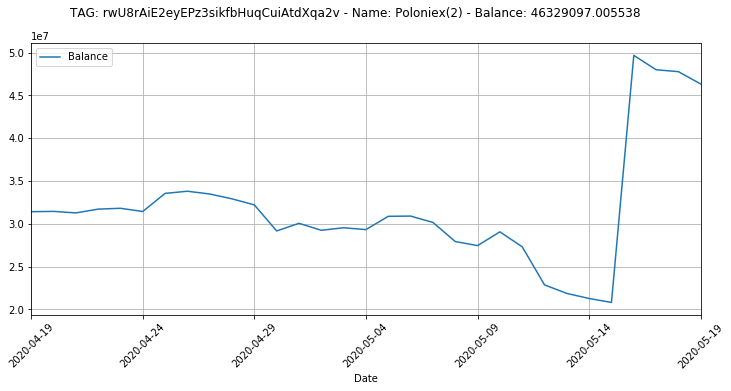

In [32]:
import matplotlib.pyplot as plt

df_balance[['Balance']].plot(grid=True, figsize=(12, 5))
plt.suptitle('TAG: {} - Name: {} - Balance: {}'.format(ACCOUNT_ADDRESS, account_name, df_balance['Balance'].tail(1).values[0]))
plt.xticks(rotation=45)
plt.show()

## Find Transactions

In [5]:
if not dir().count('df_account'):
    df_account = get_account()

print(ACCOUNT_ADDRESS)
data = get_transactions(ACCOUNT_ADDRESS, days=100, limit=1000, descending=True)
df_trans = convert_to_dataframe(ACCOUNT_ADDRESS, data)
df_trans

rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy


,account,Account Desc,Date,Tx hash,From,From Desc,Type,Flow,To,To Desc,DT,Amount,Currency,Issuer,Delivered Amount,Fee,Result
0,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,2020-05-21T09:47:12+00:00,61A252FFA0F277A3B34AAC6D55D5DF12622D42D0711114...,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,Payment,OUT,rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg,Coinbase(2),1109927167,1315.459274,,,1315.459274,0.000012,tesSUCCESS
1,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,2020-05-21T09:42:30+00:00,0A0DAFE618E6754C46ADA30F166A41BAF22BD024C5B4FE...,rHUAEDchvGi6FcckvjvnQdKX7tC2Jiwb3f,Unknow,Payment,IN,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,1484843783,1816.000000,,,1816.000000,0.001000,tesSUCCESS
2,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,2020-05-21T09:40:11+00:00,EB545F8D4E211E3DF189930C1F2197B7A78AB6F2FED824...,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,Payment,OUT,rnMCfd99pwRE8u4LxE43Z1pDzock2kXbLQ,Unknow,368947726,105.389946,,,105.389946,0.000012,tesSUCCESS
3,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,2020-05-21T09:38:52+00:00,E95ECD06B3ADEC615C6884BF421250024900004A1261FC...,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,Payment,OUT,rLHzPsX6oXkzU2qL12kHCH8G8cnZv1rBJh,Kraken,899314579,102.000000,,,102.000000,0.000012,tesSUCCESS
4,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,2020-05-21T09:35:32+00:00,1765B7430266D6F30FA6434F5FC55066347E80F3BA99C9...,raoDM1miEjHvbmkRvpXiXzxwTb3SVNBisr,Unknow,Payment,IN,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,944691930,0.000909,,,0.000909,0.000010,tesSUCCESS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,2020-05-20T01:13:22+00:00,875D1F7A98516F0CA7AEBA4E213223A9B2A349EC57CA81...,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,Payment,OUT,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3138103982,1315.000000,,,1315.000000,0.000012,tesSUCCESS
996,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,2020-05-20T01:12:41+00:00,43F638586937E576171A3EE36345B44124AFAA409CFFF0...,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,Payment,OUT,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3138103982,1252.755000,,,1252.755000,0.000012,tesSUCCESS
997,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,2020-05-20T01:11:51+00:00,D80C6C9743F50018C1F0928F3511A357E2B29B8A0F1B33...,rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),Payment,IN,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,748498480,2700.000000,,,2700.000000,0.100000,tesSUCCESS
998,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,2020-05-20T01:11:21+00:00,D5D8AE92A3DB8BF10E3A3744D6163F91ACF0A39FC87816...,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,Payment,OUT,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3138103982,697.000000,,,697.000000,0.000012,tesSUCCESS


## Monitor flow IN/OUT

In [6]:
df_flow_in = df_trans.loc[df_trans.Flow == 'IN'].groupby(['From', 'From Desc','To','To Desc','DT'])['Amount'].agg(['count', "sum"])
df_flow_in.sort_values('sum', ascending=False, inplace=True)
df_flow_in

count  \
From                               From Desc    To                                 To Desc DT                  
rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy Binance(2)   rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 1829104356      1   
rNQEMJA4PsoSrZRn9J6RajAYhcDzzhf8ok Coincheck(1) rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 1131153177      1   
rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy Binance(2)   rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 445357277      14   
rCyNZkXXwN8983WyHUMdMnJmARQRRYtHH  Unknow       rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 217988691       1   
r9HwsqBnAUN4nF6nDqxd4sgP8DrDnDcZP3 BitBay       rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 1065541638      5   
...                                                                                                      ...   
rAPERVgXZavGgiGv6xBgtiZurirW2yAmY  Dropz        rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 1356893753      1   
                                                                                           226877041       1   
                                                                                           1711571221      1   
                                                                                           545815262       1   
                                                                                           1203605203      1   

                                                                                                                 sum  
From                               From Desc    To                                 To Desc DT                         
rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy Binance(2)   rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 1829104356  499999.750000  
rNQEMJA4PsoSrZRn9J6RajAYhcDzzhf8ok Coincheck(1) rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 1131153177  290091.640221  
rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy Binance(2)   rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 445357277   205473.500000  
rCyNZkXXwN8983WyHUMdMnJmARQRRYtHH  Unknow       rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 217988691    98000.000000  
r9HwsqBnAUN4nF6nDqxd4sgP8DrDnDcZP3 BitBay       rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 1065541638   96000.000000  
...                                                                                                              ...  
rAPERVgXZavGgiGv6xBgtiZurirW2yAmY  Dropz        rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex 1356893753       0.010200  
                                                                                           226877041        0.010100  
                                                                                           1711571221       0.003000  
                                                                                           545815262        0.002000  
                                                                                           1203605203       0.000300  

[259 rows x 2 columns]

In [7]:
df_flow_out = df_trans.loc[df_trans.Flow == 'OUT'].groupby(['From', 'From Desc','To','To Desc','DT'])['Amount'].agg(['count',"sum"])
df_flow_out.sort_values('sum', ascending=False, inplace=True)
df_flow_out

count  \
From                               From Desc To                                 To Desc     DT                  
rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex   rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh Binance(1)  105602972       1   
                                                                                            106281754       2   
                                             rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg Coinbase(2) 3434336864      7   
                                             rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v Poloniex(2) 1165551230      2   
                                             rDsbeomae4FXwgQTJp9Rs64Qg9vDiTCdBv Bitstamp(1) 60796639        4   
...                                                                                                       ...   
                                             rU2mEJSLqBRkYLVTv55rFTgQajkLTnT6mA Coins.ph(1) 343372          1   
                                                                                            307452          1   
                                                                                            224255          1   
                                             rBz53UihqM1WCxo7QEKej6YbgdQGgdBKTE Unknow      0               1   
                                             rsekGH9p9neiPxym2TMJhqaCzHFuokenTU Bitsler     639870295       1   

                                                                                                                  sum  
From                               From Desc To                                 To Desc     DT                         
rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex   rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh Binance(1)  105602972   229921.000000  
                                                                                            106281754   154887.063256  
                                             rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg Coinbase(2) 3434336864  142449.000000  
                                             rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v Poloniex(2) 1165551230   99510.000000  
                                             rDsbeomae4FXwgQTJp9Rs64Qg9vDiTCdBv Bitstamp(1) 60796639     86425.000000  
...                                                                                                               ...  
                                             rU2mEJSLqBRkYLVTv55rFTgQajkLTnT6mA Coins.ph(1) 343372           8.842520  
                                                                                            307452           8.636920  
                                                                                            224255           3.780070  
                                             rBz53UihqM1WCxo7QEKej6YbgdQGgdBKTE Unknow      0                3.000000  
                                             rsekGH9p9neiPxym2TMJhqaCzHFuokenTU Bitsler     639870295        2.139589  

[425 rows x 2 columns]

## Export data to Excel

In [12]:
date_time = datetime.now().strftime("%Y-%m-%d")
dfs = {'account_info': df_account_info_x, 'balance': df_balance, 'transactions': df_trans, 'flow_in': df_flow_in, 'flow_out': df_flow_out}
filename = 'data/{}-TAG_FLOW-{}-{}.xlsx'.format(date_time, account_name, ACCOUNT_ADDRESS)
DF_TO_EXCEL_MUL(dfs, filename)
print(filename)
print('Done!')

data/2020-05-19-TAG_FLOW-Bittrex-rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKyx.xlsx
Done!


# XRP NET

## Flow In

In [113]:
df_flow_in[['From','From Desc', 'To', 'To Desc','DT']]

,From,From Desc,To,To Desc,DT
0,rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,1829104356
1,rNQEMJA4PsoSrZRn9J6RajAYhcDzzhf8ok,Coincheck(1),rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,1131153177
2,rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,445357277
3,rCyNZkXXwN8983WyHUMdMnJmARQRRYtHH,Unknow,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,217988691
4,r9HwsqBnAUN4nF6nDqxd4sgP8DrDnDcZP3,BitBay,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,1065541638
...,...,...,...,...,...
254,rAPERVgXZavGgiGv6xBgtiZurirW2yAmY,Dropz,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,1356893753
255,rAPERVgXZavGgiGv6xBgtiZurirW2yAmY,Dropz,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,226877041
256,rAPERVgXZavGgiGv6xBgtiZurirW2yAmY,Dropz,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,1711571221
257,rAPERVgXZavGgiGv6xBgtiZurirW2yAmY,Dropz,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,545815262


In [159]:
def get_flow_in_out(ACCOUNT_ADDRESS):
    data = get_transactions(ACCOUNT_ADDRESS, days=10,
                            limit=100, descending=True)
    df_trans = convert_to_dataframe(ACCOUNT_ADDRESS, data)
    
    df_flow_in = pd.DataFrame()
    df_flow_out = pd.DataFrame()
    
    if df_trans.empty == False:
        # count & sum amount by flow IN/OUT
        df_flow_in = df_trans.loc[df_trans.Flow == 'IN'].groupby(
            ['From', 'From Desc', 'To', 'To Desc', 'DT'])['Amount'].agg(['count', "sum"])
        df_flow_in.sort_values('sum', ascending=False, inplace=True)

        df_flow_out = df_trans.loc[df_trans.Flow == 'OUT'].groupby(
            ['From', 'From Desc', 'To', 'To Desc', 'DT'])['Amount'].agg(['count', "sum"])
        df_flow_out.sort_values('sum', ascending=False, inplace=True)
        
    return df_flow_in, df_flow_out

In [160]:
df_flow_in, df_flow_out = get_flow_in_out(ACCOUNT_ADDRESS)
df_flow_out

count  \
From                               From Desc To                                 To Desc                DT                  
rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex   rw7m3CtVHwGSdhFjV4MyJozmZJv3DYQnsA bitbank(2)             110376394       1   
                                             rwU8rAiE2eyEPz3sikfbHuqCuiAtdXqa2v Poloniex(2)            1165551230      1   
                                             raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA Unknow                 3205278378      2   
                                             rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg Coinbase(2)            3434336864      2   
                                             raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA Unknow                 301640361       1   
                                             rMvYS27SYs5dXdFsUgpvv1CSrPsCz7ePF5 Binance US(2)          100075136       2   
                                             rDsbeomae4FXwgQTJp9Rs64Qg9vDiTCdBv Bitstamp(1)            60796639        1   
                                             rUW9toSjQkLY6EspdnBJP2paG4hWKmNbMh KuCoin(1)              1862060151      1   
                                             rEXwQPLroXWpignyXV2sX9mQi75BAJj8Yw Unknow                 103937          1   
                                             rwwFjRZcU8HKN9CPZ8E8Q4ZJEZyNMr9MDc Unknow                 0               1   
                                             rn4wKZyD66wM7CZtNsQrjQ12ABFuAkDvXc Unknow                 0               3   
                                             rNqfM1NKVteiSLQDi3QckcVAaT5udigL2Y Unknow                 0               1   
                                             rUzWJkXyEtT8ekSSxkBYPqCvHpngcy6Fks OKEx                   84676           1   
                                             raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA Unknow                 1599908522      1   
                                                                                                       3416173225      1   
                                             rKV8HEL3vLc6q9waTiJcewdRdSFyx67QFb Crypto.com Exchange(1) 2226205739      1   
                                             rAJGLDjPPbHUNnM5VhLVRVRLP3Z95xWyH  Unknow                 0               1   
                                             rpXSZNtbaDR4UMVQbVNrGiJw9SKbM2XUx8 Unknow                 0               2   
                                             rQsypgKWXaZFxv185kV1r92hd94ao7EVHF Unknow                 0               2   
                                             rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg Coinbase(2)            1761434855      1   
                                                                                                       513409419       1   
                                             rHL26BxBkh7pqpzpHRW3LZ1Z8hfvK11Ffi Unknow                 0               1   
                                             raLPjTYeGezfdb6crXZzcC8RkLBEwbBHJ5 Bitrue(2)              18616804        1   
                                             rKV8HEL3vLc6q9waTiJcewdRdSFyx67QFb Crypto.com Exchange(1) 3356472825      3   
                                             raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA Unknow                 3600919208      1   
                                             rP3JwhueyZaKdJaBm2vEyXUkK9ToKLpewy Unknow                 0               1   
                                             raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA Unknow                 1883679403      1   
                                             rsRy14FvipgqudiGmptJBhr1RtpsgfzKMM Luno(1)                3864063106      1   
                                             raJt8gL4AoADBnCBkkSHLMSnUKjL6dXpVk Unknow                 0               2   
                                             rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh Binance(1)             102097865       3   
                                             rwiCA5hc96q3HskuinTEwf1b5JvpQhWSdw Unknow                 0               1   
                       

In [161]:
nodes = []
edges = []

df_account = get_account()
df_account.fillna('', inplace=True)
df_acc = df_account[['name', 'account','desc','XRP']].loc[df_account['name'] == 'Bittrex'].copy(deep=True)
df_acc['id'] = df_acc['account']
df_acc['label'] = df_acc['name'] + '(' + df_acc['desc'] + ') XRP: ' + df_acc['XRP'].astype(str)
df_acc[['id', 'label']]

# Parrent Node
for _, row in df_acc[['id', 'label']].iterrows():
    nodes.append(dict(row))

In [173]:

def xrpnet(ACCOUNT_ADDRESS):
    
    print(ACCOUNT_ADDRESS)
    
    df_flow_in, df_flow_out = get_flow_in_out(ACCOUNT_ADDRESS)
    
    if df_flow_in.empty or df_flow_out.empty:
        print('Transactions is Empty!')
        return False
    
    df_flow_in.reset_index(inplace=True)
    df_flow_out.reset_index(inplace=True)
    
    # Flow IN - Nodes
    print('Flow IN - Nodes')
    df_in = df_flow_in[['From','From Desc', 'To', 'To Desc','DT']].head(20)

    df_in['id'] = df_in['From'] + '-' + df_in['DT'].astype(str)
    df_in['label'] = 'From: ' + df_in['From Desc'] + ' To: ' + df_in['To Desc'] + ' DT: ' + df_in['DT'].astype(str)
    df_in['Not Have'] = df_in['id'].apply(lambda x: find_account(x))
    
    df_in = df_in.loc[df_in['Not Have'] == False]
    
    if df_in.empty == False:
        for index, row in df_in[['id','label']].iterrows():
            nodes.append(dict(row))

        # Flow In - Edges
        df_in['label'] =   df_in['To Desc'] + ' DT:' + df_in['DT'].astype(str)

        for _, row in df_in.iterrows():
            edges.append(
                {
                    "from": row['From'] + "-" + str(row['DT']),
                    "to": row['To'],
                    "label": row['label'],
                    "color": {
                        "color": "green",
                        "highlight": "blue"
                    },
                    "arrows": {
                        "from": {
                            "scaleFactor": "1.25",
                            "type": "circle"
                        }
                    }
                }
            )

    # Flow OUT - Nodes
    print('Flow OUT - Nodes')
    df_out = df_flow_out.reset_index()[['From','From Desc', 'To', 'To Desc','DT']].head(20)
    to_desc = df_flow_in[:1]['To Desc'].values[0]

    df_out['id'] = df_out['To'] + '-' + df_out['DT'].astype(str)
    df_out['label'] = 'From: ' + df_out['From Desc'] + ' To: ' + df_out['To Desc'] + ' DT: ' + df_out['DT'].astype(str)
    df_out['Not Have'] = df_out['id'].apply(lambda x: find_account(x))
    
    df_out = df_out.loc[df_out['Not Have'] == False]
    
    if df_out.empty == False:
        for index, row in df_out[['id','label']].iterrows():
            nodes.append(dict(row))

        # Flow OUT - Edges
        df_out['label'] =   df_out['To Desc'] + ' DT:' + df_out['DT'].astype(str)

        for _, row in df_out.iterrows():
            edges.append(
                {
                    "from": str(row['From']),
                    "to": '{}-{}'.format(row['To'], str(row['DT'])),
                    "label": row['label'],
                    "color": {
                        "color": "red",
                        "highlight": "yellow"
                    },
                    "arrows": {
                        "from": {
                            "scaleFactor": "1.25",
                            "type": "circle"
                        }
                    }
                }
            )
            if find_account(row['To']) == False:
                xrpnet(row['To'])


In [175]:
ACCOUNT_ADDRESS = 'rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy'

nodes = []
edges = []

df_account = get_account()
df_account.fillna('', inplace=True)
df_acc = df_account[['name', 'account','desc','XRP']].loc[df_account['name'] == 'Bittrex'].copy(deep=True)
df_acc['id'] = df_acc['account']
df_acc['label'] = df_acc['name'] + '(' + df_acc['desc'] + ') XRP: ' + df_acc['XRP'].astype(str)
df_acc[['id', 'label']]

# Parrent Node
for _, row in df_acc[['id', 'label']].iterrows():
    nodes.append(dict(row))
    

xrpnet(ACCOUNT_ADDRESS)
# Write to JSON
result = {
    'nodes':nodes,
    'edges':edges
}

with open('xrpnet/xrpnet-ui/data/test.json', 'w') as json_file:
    json.dump(result, json_file)
    
print('Done')

rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy
Flow IN - Nodes
Flow OUT - Nodes
rw7m3CtVHwGSdhFjV4MyJozmZJv3DYQnsA
Flow IN - Nodes
Flow OUT - Nodes
rwggnsfxvCmDb3YP9Hs1TaGvrPR7ngrn7Z
Flow IN - Nodes
Flow OUT - Nodes
r97KeayHuEsDwyU1yPBVtMLLoQr79QcRFe
Flow IN - Nodes
Flow OUT - Nodes
rJn2zAPdFA193sixJwuFixRkYDUtx3apQh
Transactions is Empty!
rfmMjAXq65hpAxEf1RLNQq6RgYTSVkQUW5
Flow IN - Nodes
Flow OUT - Nodes
rwPbLSqTDYwvCsGZEzDTNo3SgzCwEjQdWZ
unable to retrieve transactions
Transactions is Empty!
rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh
unable to retrieve transactions
Transactions is Empty!
r3afNCJVUY7RRoFBv6jwXQQyitadMEBoHC
Transactions is Empty!
rKcVYzVK1f4PhRFjLhWP7QmteG5FpPgRub
Flow IN - Nodes
Flow OUT - Nodes
rHBC8fxeQm9e3HbUYxXRqHvbwmjVhKsTqv
Flow IN - Nodes
Flow OUT - Nodes
rErM4RfWKq8fmjrmGURbR193ypJoLAAiR7
Flow IN - Nodes
Flow OUT - Nodes
rh6eAhYMd8NzjdjGcb2ip98hU5HVaYTtRM
Flow IN - Nodes
Flow OUT - Nodes
rDsbeomae4FXwgQTJp9Rs64Qg9vDiTCdBv
Flow IN - Nodes
Flow OUT - Nodes
rLSn6Z3T8uCxbcd1oxwfGQN1

KeyboardInterrupt: 

In [278]:
def find_account(acc):
    for d in nodes:
        #print('{}=={}'.format(d['id'], acc))
        v = d['id'] if d['id'] == acc else False
        if v != False:
            return True
    return False

## Test Flow

In [181]:
ACCOUNT_ADDRESS = 'rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy'

nodes = []
edges = []

df_account = get_account()
df_account.fillna('', inplace=True)
df_acc = df_account[['name', 'account','desc','XRP']].loc[df_account['name'] == 'Bittrex'].copy(deep=True)
df_acc['id'] = df_acc['account']
df_acc['label'] = df_acc['name'] + '(' + df_acc['desc'] + ') XRP: ' + df_acc['XRP'].astype(str)
df_acc[['id', 'label']]

# Parrent Node
for _, row in df_acc[['id', 'label']].iterrows():
    nodes.append(dict(row))

In [324]:
# Write to JSON
result = {
    'nodes':nodes,
    'edges':edges
}

with open('xrpnet/xrpnet-ui/data/test.json', 'w') as json_file:
    json.dump(result, json_file)
    
print('Done')

Done


In [177]:
ACCOUNT_ADDRESS = 'rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy'
print(ACCOUNT_ADDRESS)

df_flow_in, df_flow_out = get_flow_in_out(ACCOUNT_ADDRESS)
df_flow_out

rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy


count  \
From                               From Desc To                                 To Desc                DT                  
rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy Bittrex   raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA Unknow                 3491474091      1   
                                                                                                       3178212008      2   
                                             rUW9toSjQkLY6EspdnBJP2paG4hWKmNbMh KuCoin(1)              1861149630      1   
                                             raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA Unknow                 301640361       2   
                                                                                                       3082922664      1   
                                                                                                       3060640425      1   
                                             rPRquDmusgmcvvXkz56XYGZ1BuBaEKB3qN Bitcasino              2849591679      3   
                                             rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh Binance(1)             101540038       1   
                                             rUEfYyerfok6Yo38tTTTZKeRefNh9iB1Bd Bitpanda(1)            0               2   
                                             rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg Coinbase(2)            3434336864      1   
                                             rDsbeomae4FXwgQTJp9Rs64Qg9vDiTCdBv Bitstamp(1)            60796639        1   
                                             raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA Unknow                 2615847595      1   
                                             rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh Binance(1)             104047244       1   
                                             rNqfM1NKVteiSLQDi3QckcVAaT5udigL2Y Unknow                 0               1   
                                             raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA Unknow                 3416173225      2   
                                             rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh Binance(1)             108522415       1   
                                             rMAT58gcdC7hCUs5Bi9UQa3DQV8bq6YDyQ Unknow                 0               1   
                                             rKV8HEL3vLc6q9waTiJcewdRdSFyx67QFb Crypto.com Exchange(1) 4275314716      1   
                                             rUW9toSjQkLY6EspdnBJP2paG4hWKmNbMh KuCoin(1)              1863224212      1   
                                             rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh Binance(1)             100047462       1   
                                             rwiiJ2WpkWi9Jm9D5SefQBiVqWYpskuZNu Unknow                 0               1   
                                             rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg Coinbase(2)            2176988394      1   
                                             rwuAm7XdcP3SBwgJrVthCvCzU7kETJUUit WazirX(1)              526208357       1   
                                             raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA Unknow                 3098061486      1   
                                             rMnxNu9cBj7CrsAzpM18pCbgPZFFb5tsKj Unknow                 0               2   
                                             r4qbHmme48C33ucwSeAj1aFwYhzMwV6QP6 Unknow                 0               1   
                                             rCoinaUERUrXb1aA7dJu8qRcmvPNiKS3d  CoinPayments           93436932        1   
                                             rDsbeomae4FXwgQTJp9Rs64Qg9vDiTCdBv Bitstamp(1)            51337344        1   
                                             rNeyasCQCJBcF3DPutYLEwuT2B8GhpHFyW Unknow                 0               2   
                                             rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg Coinbase(2)            2582871407      1   
                                             rGZV96HKpRbPCHbeYdtqE8Z5F74ULZ8o7E Unknow                 1094            1   
                       

In [360]:
nodes = []
edges =[]

In [361]:
df_in = df_flow_in.reset_index()[['From','From Desc', 'To', 'To Desc','DT','count','sum']]

df_in['id'] = df_in['From'] + '-' + df_in['DT'].astype(str)
df_in['label'] = ' To: ' + df_in['To Desc'] + ' DT: ' + df_in['DT'].astype(str)

df_in['From Already'] = df_in['From'].apply(lambda x: find_account(x))
df_in['Tag Already'] = df_in['id'].apply(lambda x: find_account(x))
df_in['Dest Already'] = df_in['To'].apply(lambda x: find_account(x))

df_inx = df_in.loc[df_in['From Already'] == False]
df_inx = df_inx[['From','From Desc']].rename(columns={'From':'id', 'From Desc': 'label'})
df_inx.drop_duplicates(subset ="id", keep = 'first', inplace = True)
if df_inx.empty == False:
    for index, row in df_inx[['id','label']].iterrows():
        nodes.append(dict(row))

df_inx = df_in[['id','label']].loc[df_in['Tag Already'] == False]
if df_inx.empty == False:
    for index, row in df_inx[['id','label']].iterrows():
        nodes.append(dict(row))

df_inx = df_in.loc[df_in['Dest Already'] == False]
df_inx = df_inx[['To','To Desc']].rename(columns={'To':'id', 'To Desc': 'label'})
df_inx.drop_duplicates(subset ="id", keep = 'first', inplace = True)
if df_inx.empty == False:
    for index, row in df_inx[['id','label']].iterrows():
        nodes.append(dict(row))
        
print('Done')


Done


In [362]:

# From to DT
for _, row in df_in.iterrows():
    edges.append(
        {
            "from": str(row['From']),
            "to": '{}-{}'.format(row['From'], str(row['DT'])),
            "label": row['To Desc'] + ' DT:' + str(row['DT']),
            "color": {
                "color": "green",
                "highlight": "yellow"
            },
            "arrows": {
                "from": {
                    "scaleFactor": "0.5",
                    "type": "circle"
                }
            }
        }
    )

# DT to Dest
for _, row in df_in.iterrows():
    edges.append(
        {
            "from": '{}-{}'.format(row['From'], str(row['DT'])),
            "to": str(row['To']),
            "label": 'XRP:' + str(row['sum']),
            "color": {
                "color": "green",
                "highlight": "yellow"
            },
            "arrows": {
                "from": {
                    "scaleFactor": "0.5",
                    "type": "circle"
                }
            }
        }
    )
print('Done')


Done


## Flow Out

In [354]:
df_out = df_flow_out.reset_index()[['From','From Desc', 'To', 'To Desc','DT','count','sum']]
df_out

,From,From Desc,To,To Desc,DT,count,sum
0,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3491474091,1,159707.175524
1,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3178212008,2,142152.213658
2,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,rUW9toSjQkLY6EspdnBJP2paG4hWKmNbMh,KuCoin(1),1861149630,1,71863.125278
3,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,301640361,2,48468.315224
4,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3082922664,1,40635.494096
5,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3060640425,1,36736.965820
6,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,rPRquDmusgmcvvXkz56XYGZ1BuBaEKB3qN,Bitcasino,2849591679,3,24997.000000
7,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh,Binance(1),101540038,1,23694.446778
8,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,rUEfYyerfok6Yo38tTTTZKeRefNh9iB1Bd,Bitpanda(1),0,2,23175.293860
9,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg,Coinbase(2),3434336864,1,14012.000000


In [356]:
df_out

,From,From Desc,To,To Desc,DT,count,sum,id,label,From Already,Tag Already,Dest Already
0,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3491474091,1,159707.175524,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA-3491474091,To: Unknow DT: 3491474091,True,False,False
1,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3178212008,2,142152.213658,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA-3178212008,To: Unknow DT: 3178212008,True,False,False
2,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,rUW9toSjQkLY6EspdnBJP2paG4hWKmNbMh,KuCoin(1),1861149630,1,71863.125278,rUW9toSjQkLY6EspdnBJP2paG4hWKmNbMh-1861149630,To: KuCoin(1) DT: 1861149630,True,False,False
3,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,301640361,2,48468.315224,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA-301640361,To: Unknow DT: 301640361,True,False,False
4,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3082922664,1,40635.494096,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA-3082922664,To: Unknow DT: 3082922664,True,False,False
5,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA,Unknow,3060640425,1,36736.965820,raQwCVAJVqjrVm1Nj5SFRcX8i22BhdC9WA-3060640425,To: Unknow DT: 3060640425,True,False,False
6,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,rPRquDmusgmcvvXkz56XYGZ1BuBaEKB3qN,Bitcasino,2849591679,3,24997.000000,rPRquDmusgmcvvXkz56XYGZ1BuBaEKB3qN-2849591679,To: Bitcasino DT: 2849591679,True,False,False
7,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh,Binance(1),101540038,1,23694.446778,rEb8TK3gBgk5auZkwc6sHnwrGVJH8DuaLh-101540038,To: Binance(1) DT: 101540038,True,False,False
8,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,rUEfYyerfok6Yo38tTTTZKeRefNh9iB1Bd,Bitpanda(1),0,2,23175.293860,rUEfYyerfok6Yo38tTTTZKeRefNh9iB1Bd-0,To: Bitpanda(1) DT: 0,True,False,False
9,rPVMhWBsfF9iMXYj3aAzJVkPDTFNSyWdKy,Bittrex,rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg,Coinbase(2),3434336864,1,14012.000000,rw2ciyaNshpHe7bCHo4bRWq6pqqynnWKQg-3434336864,To: Coinbase(2) DT: 3434336864,True,False,False


In [363]:
df_out = df_flow_out.reset_index()[['From','From Desc', 'To', 'To Desc','DT','count','sum']].head(10)

df_out['id'] = df_out['To'] + '-' + df_out['DT'].astype(str)
df_out['label'] = ' To: ' + df_out['To Desc'] + ' DT: ' + df_out['DT'].astype(str)

df_out['From Already'] = df_out['From'].apply(lambda x: find_account(x))
df_out['Tag Already'] = df_out['id'].apply(lambda x: find_account(x))
df_out['Dest Already'] = df_out['To'].apply(lambda x: find_account(x))

df_outx = df_out.loc[df_out['From Already'] == False]
df_outx = df_outx[['From','From Desc']].rename(columns={'From':'id', 'From Desc': 'label'})
df_outx.drop_duplicates(subset ="id", keep = 'first', inplace = True)
if df_outx.empty == False:
    for index, row in df_outx[['id','label']].iterrows():
        nodes.append(dict(row))

df_outx = df_out[['id','label']].loc[df_out['Tag Already'] == False]
if df_outx.empty == False:
    for index, row in df_outx[['id','label']].iterrows():
        nodes.append(dict(row))

df_outx = df_out.loc[df_in['Dest Already'] == False]
df_outx = df_outx[['To','To Desc']].rename(columns={'To':'id', 'To Desc': 'label'})
df_outx.drop_duplicates(subset ="id", keep = 'first', inplace = True)
if df_outx.empty == False:
    for index, row in df_outx[['id','label']].iterrows():
        nodes.append(dict(row))
        
print('Done')


Done


In [364]:

# From to DT
for _, row in df_out.iterrows():
    edges.append(
        {
            "from": str(row['From']),
            "to": '{}-{}'.format(row['To'], str(row['DT'])),
            "label": row['To Desc'] + ' DT:' + str(row['DT']),
            "color": {
                "color": "red",
                "highlight": "red"
            },
            "arrows": {
                "from": {
                    "scaleFactor": "0.5",
                    "type": "circle"
                }
            }
        }
    )

# DT to Dest
for _, row in df_out.iterrows():
    edges.append(
        {
            "from": '{}-{}'.format(row['To'], str(row['DT'])),
            "to": str(row['To']),
            "label": 'XRP:' + str(row['sum']),
            "color": {
                "color": "red",
                "highlight": "red"
            },
            "arrows": {
                "from": {
                    "scaleFactor": "0.5",
                    "type": "circle"
                }
            }
        }
    )
print('Done')


Done


In [365]:
result = {
    'nodes':nodes,
    'edges':edges
}
with open('xrpnet/xrpnet-ui/data/test.json', 'w') as json_file:
    json.dump(result, json_file)
    
print('Done')

Done


# Get Transactions

## Main function

In [ ]:
frames = []
df_name.fillna('', inplace=True)
for _, row in df_name.iterrows():
    print('{}-{}-{}'.format(row['account'], row['name'], row['desc']))
    ACCOUNT_ADDRESS = row['account']
    data = load_transactions(ACCOUNT_ADDRESS)
    
    if data.__contains__('result'):
        if data['result'] == 'success' and data['count'] > 0:
            df_tran = convert_to_dataframe(ACCOUNT_ADDRESS, data)
            frames.append(df_tran)

df_trans = pd.concat(frames)
df_trans.tail()

## Load Account Name

In [ ]:
## Load Account Name
def load_account():
    df_name = pd.read_excel('data/List of well-known Names used to identify accounts.xlsx')
    df_name.fillna('', inplace=True)
    df_name = df_name.sort_values(by='XRP', ascending=False)
    return df_name

## Load transactions

In [ ]:
## Load transactions
def load_transactions(ACCOUNT_ADDRESS):
    start = datetime.now() - timedelta(days=90)
    date_start = start.strftime("%Y-%m-%dT%H:%M:%SZ")

    end = datetime.now()
    date_end = end.strftime("%Y-%m-%dT%H:%M:%SZ")

    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/transactions?start={date_start}&end={date_end}&type=Payment&result=tesSUCCESS&limit=1000&descending=True'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_start=date_start, date_end=date_end)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    return data

## Convert JSON to DataFrame

In [ ]:
## Convert JSON to DataFrame
def convert_to_dataframe(account, data):
    if data['result'] == "error":
        print(data['message'])
        return
    
    trans_list=[]
    for d in data['transactions']:
        account_desc = ''
        d_date = d['date']
        d_hash = d['hash']
        d_tx_from = d['tx']['Account']
        d_tx_from_desc = ''
        d_tx_type = d['tx']['TransactionType']
        d_tx_flow = ''
        d_tx_to = d['tx']['Destination']
        d_tx_to_desc = ''
        d_tx_dt = d['tx']['DestinationTag'] if d['tx'].__contains__('DestinationTag') else ''
        
        d_tx_amount = 0
        d_tx_currency = ''
        d_tx_issuer = ''
        if str(type(d['tx']['Amount'])) != "<class 'dict'>":
            d_tx_amount = float(d['tx']['Amount'])  / 1000000
        else:
            d_tx_amount = float(d['tx']['Amount']['value']) / 1000000
            d_tx_currency = d['tx']['Amount']['currency'][0:8]
            d_tx_issuer = d['tx']['Amount']['issuer']
        
        d_meta_delivered_amount = 0
        if str(type(d['meta']['delivered_amount'])) != "<class 'dict'>":
            d_meta_delivered_amount =  float(d['meta']['delivered_amount'])  / 1000000
        else:
            d_meta_delivered_amount =  float(d['meta']['delivered_amount']['value'])  / 1000000
            
        d_tx_fee = float(d['tx']['Fee']) / 1000000
        d_meta_result = d['meta']['TransactionResult']

        trans_list.append([account, account_desc, d_date, d_hash, d_tx_from, d_tx_from_desc, d_tx_type, d_tx_flow, d_tx_to, d_tx_to_desc, d_tx_dt, d_tx_amount, d_tx_currency, d_tx_issuer, d_meta_delivered_amount, d_tx_fee, d_meta_result])

    df_trans = pd.DataFrame(trans_list, columns=['account','Account Desc', 'Date','Tx hash','From','From Desc','Type','Flow','To','To Desc','DT','Amount', 'Currency', 'Issuer', 'Delivered Amount', 'Fee', 'Result'])
    
    df_trans['Account Desc'] = df_trans['account'].apply(lambda x: find_desc(x))
    df_trans['From Desc'] = df_trans['From'].apply(lambda x: find_desc(x))
    df_trans['To Desc'] = df_trans['To'].apply(lambda x: find_desc(x))
    df_trans['Flow'] = df_trans[['account', 'To']].apply(lambda x: 'IN' if x['account'] == x['To'] else 'OUT', axis=1)
    
    return df_trans


## Find Account Description

In [ ]:
def find_desc(account):
    try:
        _df = df_name.loc[df_name.account == account, ['name','desc']].astype(str)
        return '{}{}'.format(_df.name.values[0], '({})'.format(_df.desc.values[0]) if len(_df.desc.values[0]) > 0 else '')
    except:
        return 'Unknow'
    